## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [2]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [3]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [4]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [5]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

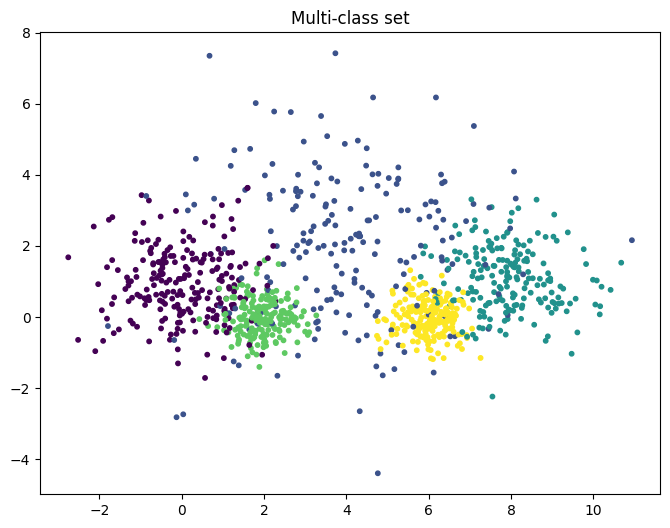

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

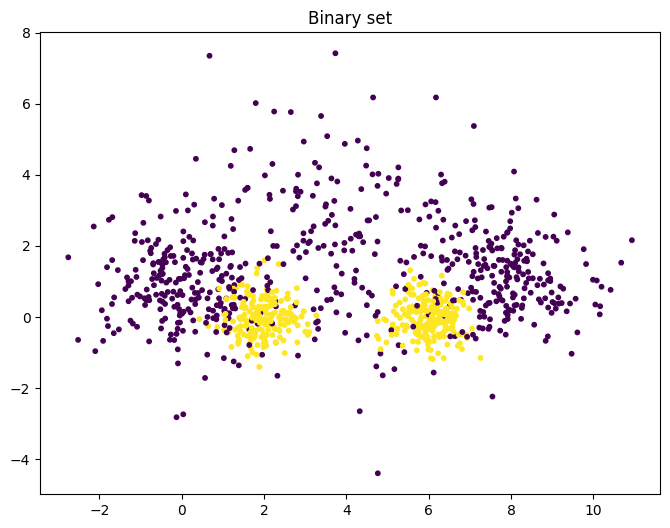

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [8]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [9]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [10]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, eta = 0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is avector of length N,
        the targets values for the training data"""
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, m) = X_train.shape
        
        self.weights = weights = np.zeros(m)
        
        for e in range(epochs):
            weights -= eta / N *  X_train.T @ (X_train @ weights - t_train)      
    
    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [11]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [12]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train)
accuracy(cl.predict(X_val), t2_val)

0.522

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [13]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

 # plt.show()

- TASK (1) - 
(1) The following plot represents the decission region of X_train... 


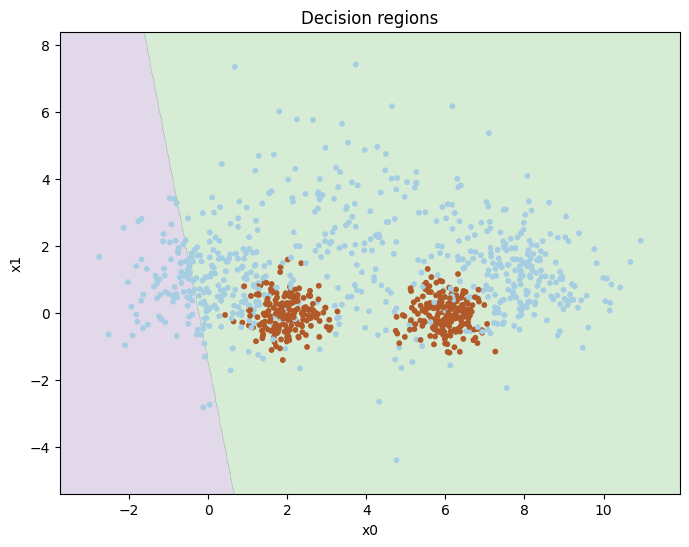

In [14]:
plot_decision_regions(X_train, t2_train, cl)
print("- TASK (1) - ")
print("(1) The following plot represents the decission region of X_train... ")

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.


+------------------+
|  TASK 1: TUNING  |
+------------------+

(1) Top result accuracy: 0.704
        ---> Eta: 0.0728643216080402 Epoch: 200

(2) Printing the top 10 results
Result (1)
   - Accuracy: 0.704
   - Eta: 0.0728643216080402
   - Epoch: 200

Result (2)
   - Accuracy: 0.7
   - Eta: 0.06587939698492462
   - Epoch: 200

Result (3)
   - Accuracy: 0.698
   - Eta: 0.0728643216080402
   - Epoch: 177

Result (4)
   - Accuracy: 0.696
   - Eta: 0.06587939698492462
   - Epoch: 177

Result (5)
   - Accuracy: 0.696
   - Eta: 0.058894472361809044
   - Epoch: 200

Result (6)
   - Accuracy: 0.692
   - Eta: 0.0728643216080402
   - Epoch: 155

Result (7)
   - Accuracy: 0.692
   - Eta: 0.06587939698492462
   - Epoch: 133

Result (8)
   - Accuracy: 0.692
   - Eta: 0.058894472361809044
   - Epoch: 155

Result (9)
   - Accuracy: 0.692
   - Eta: 0.05190954773869347
   - Epoch: 177

Result (10)
   - Accuracy: 0.692
   - Eta: 0.04492462311557789
   - Epoch: 200

(3) Plotting of decision boundaries

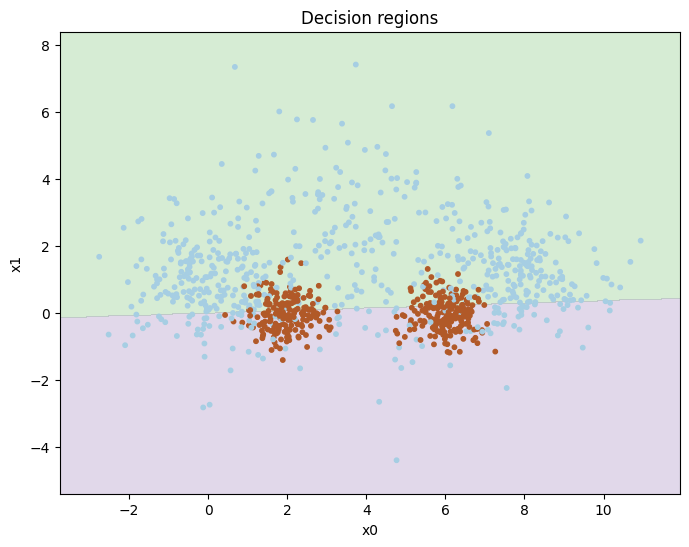

In [15]:
# our task is to try various settings for the two training hyper-parameters.
accuracy_results = []
etas_instances = [0.01, 0.05, 0.1, 0.5, 1.0]
epochs_instances = [10, 20, 30, 50, 100, 200]

etas_instances = np.linspace(0.01, 1.4, num = 200)
epochs_instances = np.linspace(0, 200, num = 10, dtype = int)

print("\n+------------------+")
print("|  TASK 1: TUNING  |")
print("+------------------+\n")

for eta_instance in etas_instances:
    for epoch_instance in epochs_instances:
        cl = NumpyLinRegClass()
        cl.fit(X_train, t2_train, eta = eta_instance, epochs = epoch_instance)
        acc = accuracy(cl.predict(X_val), t2_val)
        accuracy_results.append((acc, eta_instance, epoch_instance))

# retrieve best accuracy result from the accuracy result list. 
accuracy_results.sort(reverse = True)
top_result_accuracy, top_eta_result, top_epoch_result = accuracy_results[0]
print("(1) Top result accuracy: " + str(top_result_accuracy))
print("        ---> Eta: " + str(top_eta_result) + " Epoch: " + str(top_epoch_result) + "\n")

print("(2) Printing the top 10 results")
total_results = 1
for top_accuracy, top_eta, top_epoch in accuracy_results[:10]:
    print("Result (" + str(total_results) + ")")
    print("   - Accuracy: " + str(top_accuracy))
    print("   - Eta: " + str(top_eta))
    print("   - Epoch: " + str(top_epoch) + "\n")
    total_results += 1

print("(3) Plotting of decision boundaries \n")
classifier = NumpyLinRegClass()
classifier.fit(X_train, t2_train, eta = top_eta_result, epochs = top_epoch_result)
plot_decision_regions(X_train, t2_train, classifier)

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

In [16]:
# Import necessary libraries
import numpy as np

# Initialize an empty list to store results
results = []

# Define eta ranges for experiments
low_eta_range = np.linspace(0.001, 0.01, num=100) 
mid_eta_range = np.linspace(0.01, 0.1, num=200) 
high_eta_range = np.linspace(0.1, 1, num=200) 

# Combine all eta ranges into a single array
eta_range = np.concatenate((low_eta_range, mid_eta_range, high_eta_range))
epoch_range = np.linspace(195, 205, num=10, dtype=int)


# Iterate over all combinations of eta and epoch values
for eta in eta_range:
    for epoch in epoch_range:
        # Fit the model on the training data
        linreg = NumpyLinRegClass()
        linreg.fit(X_train, t2_train, eta=eta, epochs=epoch)
        acc = accuracy(linreg.predict(X_train), t2_train)
        results.append((acc, eta, epoch))
        

sorted_results = sorted(results, reverse=True, key=lambda x: x[0])
best_acc, best_eta, best_epoch = sorted_results[0]


In [17]:
import matplotlib.pyplot as plt # bibliotek brukt i denne oppgaven. 

# kopiert fra PDF dokumentet utlvert sammen med .ipynb filen. 
# har laget noen små endringer som gjør det lettere å lagre variabler, 
# men ingen forandringer på "hoved"-koden. 

class NumpyLinRegClass(NumpyClassifier):
    def __init__(self, bias = -1):
        self.bias = bias
        self.losses = []
        self.accuracies = []
    
    def fit(self, X_train, t_train, eta = 0.1, epochs = 10):
        if self.bias:
            X_train = add_bias(X_train, self.bias)
        
        (N, m) = X_train.shape
        self.weights = weights = np.zeros(m)

        
        for e in range(epochs):
            ys = X_train @ weights
            loss = ((ys - t_train)**2).mean()
            accuracy1 = accuracy((ys > 0.5).astype(int), t_train) 
            weights -= eta / N *  X_train.T @ (ys - t_train)
            
            self.losses.append(loss)
            self.accuracies.append(accuracy1)
    
    def predict(self, X, threshold=0.5):
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold


+------------------+
|   TASK 2: LOSS   |
+------------------+

(1) Some epochs with their respective accuracies and losses: 
Epoch (0)
   --> Accuracy: 0.614 | Loss: 0.386
Epoch (1)
   --> Accuracy: 0.614 | Loss: 0.35720564903520763
Epoch (2)
   --> Accuracy: 0.614 | Loss: 0.33245310109903586
Epoch (3)
   --> Accuracy: 0.614 | Loss: 0.3111750004760146
Epoch (4)
   --> Accuracy: 0.614 | Loss: 0.2928836345509238
Epoch (5)
   --> Accuracy: 0.614 | Loss: 0.27715975351257105
Epoch (6)
   --> Accuracy: 0.614 | Loss: 0.26364295959215195
Epoch (7)
   --> Accuracy: 0.613 | Loss: 0.2520234454923659
Epoch (8)
   --> Accuracy: 0.613 | Loss: 0.24203489259797298
Epoch (9)
   --> Accuracy: 0.613 | Loss: 0.23344836614991063
Epoch (10)
   --> Accuracy: 0.61 | Loss: 0.22606706742320604
Epoch (11)
   --> Accuracy: 0.609 | Loss: 0.2197218225978794
Epoch (12)
   --> Accuracy: 0.609 | Loss: 0.21426720490239354
Epoch (13)
   --> Accuracy: 0.605 | Loss: 0.20957820112827283
Epoch (14)
   --> Accuracy: 0.603 

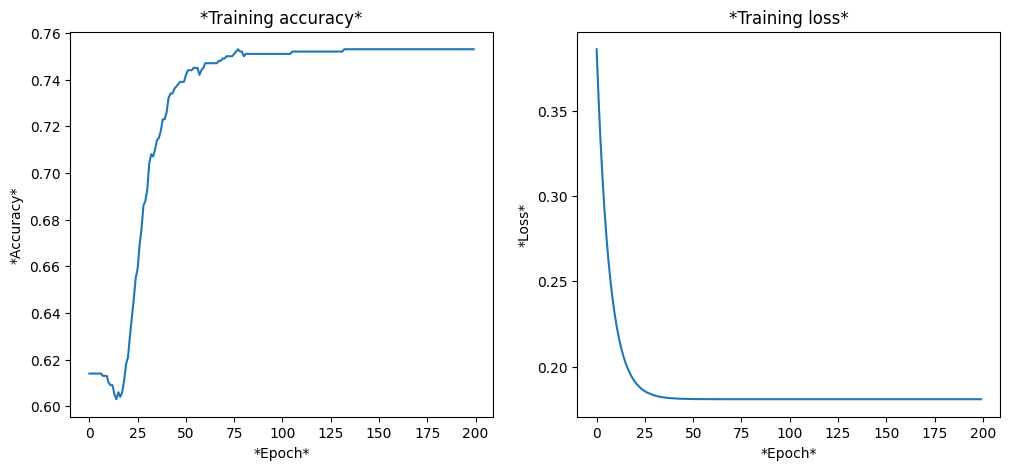

(3) Plot the decision regions


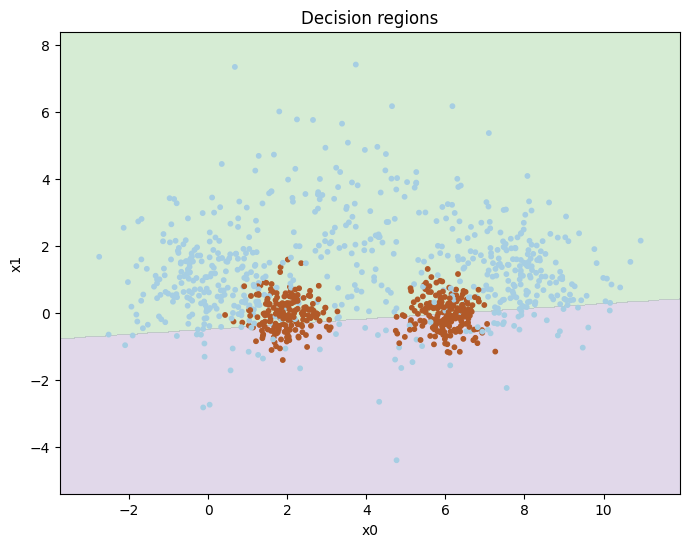

In [18]:
# - Step 1 - 
# First step is the normalization of the givend data. 

data = np.mean(X_train, axis = 0) 
standard_deviation = np.std(X_train, axis=0)
X_train_normalized = (X_train - data) / standard_deviation

# - Step 2 -
# The second step to this exercise is to train our classifier and plot the 
# the loss and accuracy 

classifier = NumpyLinRegClass()
classifier.fit(X_train_normalized, t2_train, eta= top_eta_result, epochs = top_epoch_result)
figure, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))


axis[0].plot(classifier.accuracies)
axis[0].set_xlabel('*Epoch*')
axis[0].set_ylabel('*Accuracy*')
axis[0].set_title('*Training accuracy*')


axis[1].plot(classifier.losses)
axis[1].set_xlabel('*Epoch*')
axis[1].set_ylabel('*Loss*')
axis[1].set_title('*Training loss*')


print("\n+------------------+")
print("|   TASK 2: LOSS   |")
print("+------------------+\n")

print("(1) Some epochs with their respective accuracies and losses: ")
for epochs in range(0, len(classifier.accuracies), 1):
    print("Epoch (" + str(epochs) + ")")
    print("   --> Accuracy: " + str(classifier.accuracies[epochs]) + " | Loss: " + str(classifier.losses[epochs]))

print("\n(2) Plot the loss as a function and accuracy for the number of epochs.")
plt.show()

print("(3) Plot the decision regions")
plot_decision_regions(X_train, t2_train, classifier)

plt.show()

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

In [19]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Scale the training data using StandardScaler
results = []
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [20]:
# Print section header
print("\n+--------------------+")
print("|   TASK 3: Scaling  |")
print("+--------------------+\n")

# Iterate over all combinations of eta and epoch values
for eta in eta_range:
    for epoch in epoch_range:
        # Fit the model on the scaled training data
        linreg = NumpyLinRegClass()
        linreg.fit(X_train_scaled, t2_train, eta=eta, epochs=epoch)
        acc = accuracy(linreg.predict(X_train_scaled), t2_train)
        results.append((acc, eta, epoch))
        
# Sort the results by accuracy in descending order
sorted_results = sorted(results, reverse=True, key=lambda x: x[0])
best_acc, best_eta, best_epoch = sorted_results[0]


print("(1) Plot the loss as a function and accuracy for the number of epochs.")
print("    In addition some interesting results: ")
print("       - Beste eta: " + str(best_eta))
print("       - Beste epoch: " + str(best_epoch))
print("       - Beste accuracy: " + str(best_acc))


# Fit the model with the best hyperparameters on the scaled training data and plot the decision regions
linreg = NumpyLinRegClass()
linreg.fit(X_train_scaled, t2_train, eta=best_eta, epochs=best_epoch)



+--------------------+
|   TASK 3: Scaling  |
+--------------------+

(1) Plot the loss as a function and accuracy for the number of epochs.
    In addition some interesting results: 
       - Beste eta: 0.028090452261306534
       - Beste epoch: 203
       - Beste accuracy: 0.753


(2) Plot the loss as a function and accuracy for the number of epochs.


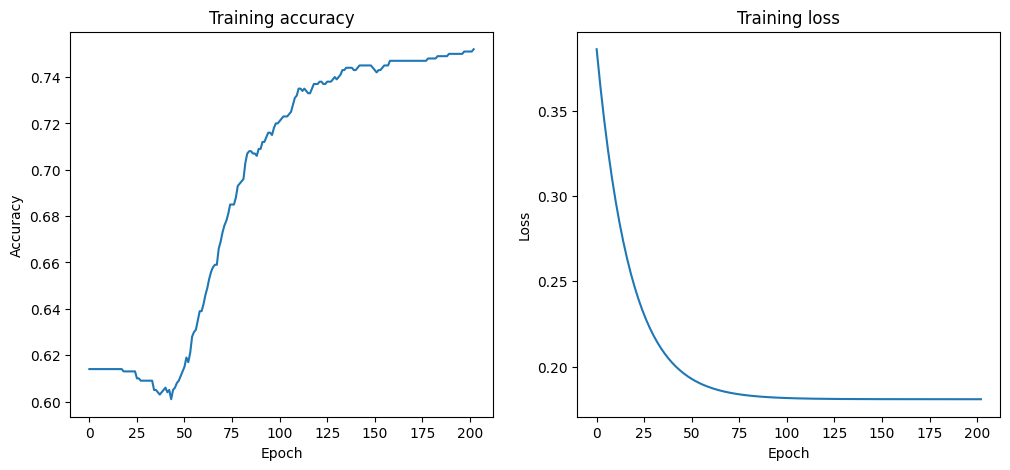

(3) Plotting of the decision regions for the scaling task


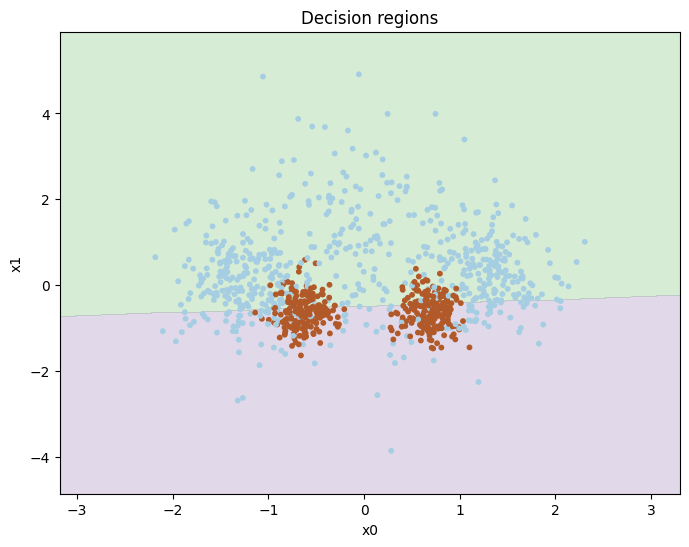

In [21]:
cl = NumpyLinRegClass()
cl.fit(X_train_scaled, t2_train, eta=best_eta, epochs=best_epoch)

# Plot the loss and accuracy as a function of the number of epochs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].plot(cl.accuracies)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training accuracy')

ax[1].plot(cl.losses)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training loss')

print("(2) Plot the loss as a function and accuracy for the number of epochs.")
plt.show()

print("(3) Plotting of the decision regions for the scaling task")
plot_decision_regions(X_train_scaled, t2_train, cl)

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [22]:
# Noen hjelpfunksjoner jeg har brukt for å løse problemet. 
def sigmoid(z):
    """ Return the sigmoid of z. """
    return 1 / (1 + np.exp(-z))

def cross_entropy_loss(y_true, y_pred):
    """
    Compute the cross-entropy loss between the true 
    labels and predicted labels.
    """
    n_samples = len(y_true)
    loss = 0.
    for i in range(n_samples):
        if y_true[i] == 1:
            loss -= np.log(sigmoid(y_pred[i]))
        else:
            loss -= np.log(1 - sigmoid(y_pred[i]))
    loss /= n_samples
    return loss

In [23]:
class NumpyLogisticRegression(NumpyClassifier):
    def __init__(self, bias=-1):
        self.bias = bias
    
    """
    The method trains a logistic regression model using gradient descent until the difference between 
    the old and new error values is smaller than the specified tolerance value. The training and validation 
    losses and accuracies are computed at each iteration and stored in their corresponding lists.
    """
    def fit(self, X_train, y_train, X_val, y_val, learning_rate=0.01, epochs=1000, tolerance=1e-4):
        # Initialize variables
        diff = 1
        losses, accuracies, losses_val, accuracies_val = [], [], [], []
        (n_samples, n_features) = X_train.shape
        
        # Add bias term to the training and validation data
        X_train_bias = add_bias(X_train, self.bias)
        X_val_bias = add_bias(X_val, self.bias)
        
        self.weights = np.zeros(n_features + 1)
        
        # Train the model using gradient descent
        while diff > tolerance:
            old_loss = cross_entropy_loss(y_train, X_train_bias @ self.weights)
            self.weights -= learning_rate / n_samples * X_train_bias.T @ (sigmoid(X_train_bias @ self.weights) - y_train)
            new_loss = cross_entropy_loss(y_train, X_train_bias @ self.weights)
            diff = old_loss - new_loss
            
            # Compute training accuracy and loss
            mse = cross_entropy_loss(y_train, X_train_bias @ self.weights)
            losses.append(mse)
            acc = self.accuracy(X_train, y_train)
            accuracies.append(acc)
            
            # Compute validation accuracy and loss
            mse_val = cross_entropy_loss(y_val, X_val_bias @ self.weights)
            losses_val.append(mse_val)
            acc_val = self.accuracy(X_val, y_val)
            accuracies_val.append(acc_val)
        
        return losses, accuracies, losses_val, accuracies_val
    
    """
    The method computes the predicted probability of the positive class 
    using the sigmoid function and the learned weights."""
    def predict_probability(self, X):
        return sigmoid(X @ self.weights)
    
    """
    The method computes the predicted probability of the positive class 
    for a given input and returns the probability as the score.
    """
    def score(self, X):
        X_bias = add_bias(X, self.bias)
        score = self.predict_probability(X_bias)
        return score
    
    """
    The method computes the predicted class label for a given input using a given 
    threshold value. The predicted class is returned as an integer (0 or 1).
    """
    def predict(self, X, threshold=0.5):
        X_bias = add_bias(X, self.bias)
        score = self.predict_probability(X_bias)
        return (score > threshold).astype('int')
    
    """
    The method computes the classification accuracy of the model for a given 
    input and true label.
    """
    def accuracy(self, X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:, 0]
        return np.sum(pred == y_test) / len(pred)



+-------------------------------------+
|   TASK II (4): LOGISTIC REGRESSION  |
+-------------------------------------+

(1) Final results for the logistic regression model
    + Loss + 
       ---> training loss: 0.5306
       ---> validation loss: 0.5438
    + Accuracy + 
       ---> training accuracy: 0.7290
       ---> validation accuracy: 0.6720
(2) Plotting of the training and validation (loss/accuracy)


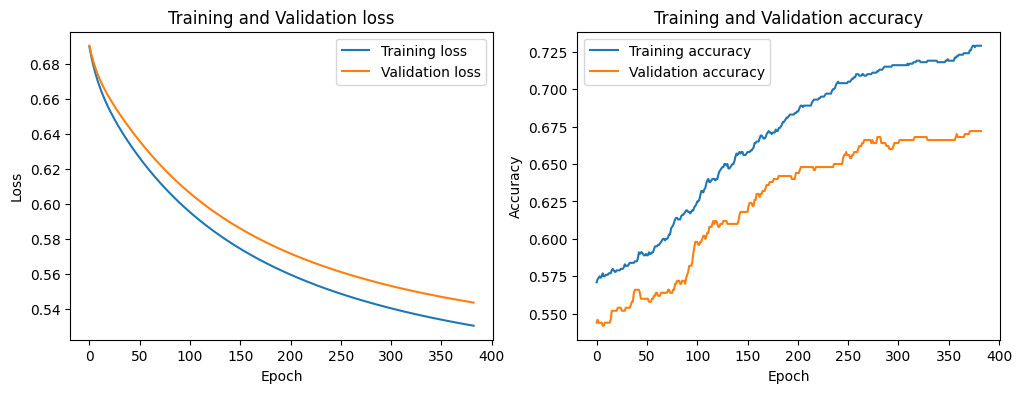

(3) Plotting of the decision boundaries


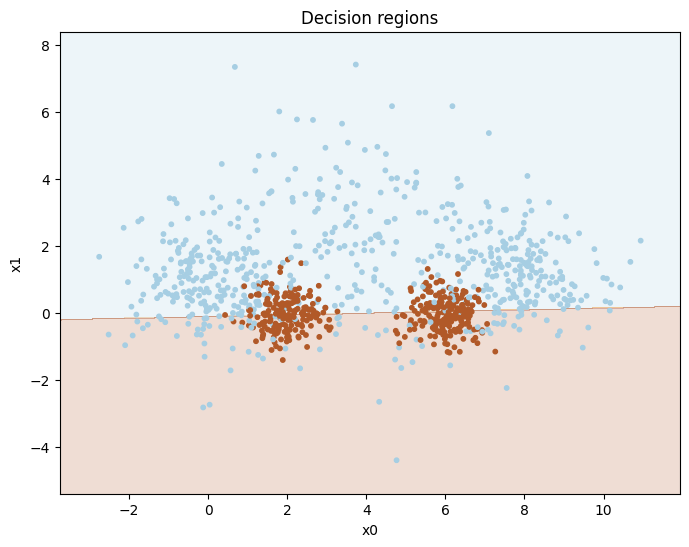

In [24]:
# Print section header
print("\n+-------------------------------------+")
print("|   TASK II (4): LOGISTIC REGRESSION  |")
print("+-------------------------------------+\n")

log_cl = NumpyLogisticRegression()
log_cl.fit(X_train, t2_train, X_val, t2_val)
log_cl.accuracy(X_val, t2_val)

losses, accuracy, losses2, accuracy2 = log_cl.fit(X_train, t2_train, X_val, t2_val)

print("(1) Final results for the logistic regression model")
print("    + Loss + ")
print(f"       ---> training loss: {losses[-1]:.4f}")
print(f"       ---> validation loss: {losses2[-1]:.4f}")
print("    + Accuracy + ")
print(f"       ---> training accuracy: {accuracy[-1]:.4f}")
print(f"       ---> validation accuracy: {accuracy2[-1]:.4f}")

log_cl = NumpyLogisticRegression()
train_losses, train_accuracies, val_losses, val_accuracies = log_cl.fit(X_train, t2_train, X_val, t2_val)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the training and validation loss
ax[0].plot(train_losses, label='Training loss')
ax[0].plot(val_losses, label='Validation loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation loss')
ax[0].legend()

# Plot the training and validation accuracy
ax[1].plot(train_accuracies, label='Training accuracy')
ax[1].plot(val_accuracies, label='Validation accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation accuracy')
ax[1].legend()

print("(2) Plotting of the training and validation (loss/accuracy)")
plt.show()

print("(3) Plotting of the decision boundaries")
plot_decision_regions(X_train, t2_train, log_cl)

I have also decided to include the following, since i thought it was pretty cool and amazing. 

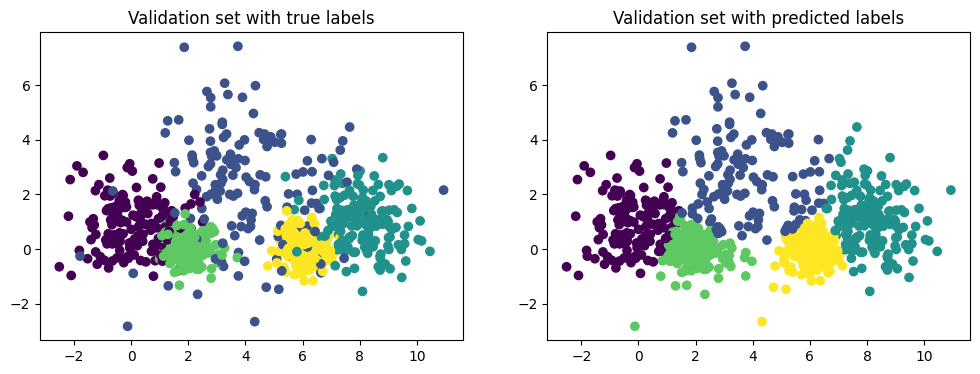

In [25]:
# not part of the exercise. 
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Split the data into training and validation sets
X_train, X_val, t_multi_train, t_multi_val = train_test_split(X, t_multi, test_size=0.4, random_state=42)

# Train the logistic regression model
learning_rate = 0.01
n_epochs = 1000
model = LogisticRegression()
model.fit(X_train, t_multi_train)

# Predict the validation set using the trained model
y_pred = model.predict(X_val)

# Plot the validation set with the predicted labels
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot the data points colored by the true labels
ax[0].scatter(X_val[:,0], X_val[:,1], c=t_multi_val)
ax[0].set_title("Validation set with true labels")

# Plot the data points colored by the predicted labels
ax[1].scatter(X_val[:,0], X_val[:,1], c=y_pred)
ax[1].set_title("Validation set with predicted labels")

plt.show()

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [26]:
class OneVsRestLogisticRegression:
    def __init__(self, bias=-1):
        self.bias = bias
        self.classifiers = []

    def fit(self, X_train, y_train, X_val, y_val, learning_rate=0.01, epochs=1000, tolerance=1e-4):
        self.unique_classes = np.unique(y_train)
        self.classifiers = []

        for cls in self.unique_classes:
            binary_y_train = (y_train == cls).astype('int')
            binary_y_val = (y_val == cls).astype('int')
            classifier = NumpyLogisticRegression(self.bias)
            classifier.fit(X_train, binary_y_train, X_val, binary_y_val, learning_rate, epochs, tolerance)
            self.classifiers.append(classifier)

    def predict(self, X):
        probabilities = []
        for classifier in self.classifiers:
            probabilities.append(classifier.score(X))
        return np.argmax(np.array(probabilities), axis=0)
    
    def accuracy(self, X_test, y_test):
        pred = self.predict(X_test)
        return np.sum(pred == y_test) / len(pred)


# OneVsRestLogisticRegression-klassen:

Denne klassen implementerer en en-mot-alle (one-vs-rest) logistisk regresjonsklassifikator. Denne tilnærmingen gjør det mulig å bruke en binær logistisk regresjonsklassifikator for flerklassedata ved å trene en klassifikator for hver klasse og sammenligne sannsynlighetene for hver klasse for å foreta prediksjoner.

1. __init__-metoden initialiserer en tom liste for å lagre logistiske regresjonsklassifikatorer for hver klasse, og tar også en "bias" verdi som et argument.

2. fit-metoden tar treningsdata og valideringsdata som inndata. Den trener en binær logistisk regresjonsmodell for hver unik klasse i datasettet ved å lage en binær målvektor for hver klasse (1 for eksemplene av den aktuelle klassen og 0 for alle andre klasser). Deretter trenes en NumpyLogisticRegression-klassifikator for hver klasse.

3. predict-metoden tar inn et datasett og returnerer predikerte klasseetiketter. Den kjører hver klassifikator (en for hver klasse) og samler sannsynlighetene. Klassen med høyest sannsynlighet blir valgt som predikert klasse.

4. accuracy-metoden tar inn et testdatasett og de sanne etikettene og beregner nøyaktigheten for klassifikatoren ved å sammenligne de predikerte etikettene med de sanne etikettene.


+------------------------------------------------+
|   TASK II (5): ONE-VS-REST LOGISTIC REGRESSION  |
+-------------------------------------------------+

(1) Final results for the one-vs-rest logistic regression model
    + Accuracy + 
       ---> training accuracy: 0.5083
       ---> validation accuracy: 0.5088
(2) Plotting of the decision boundaries


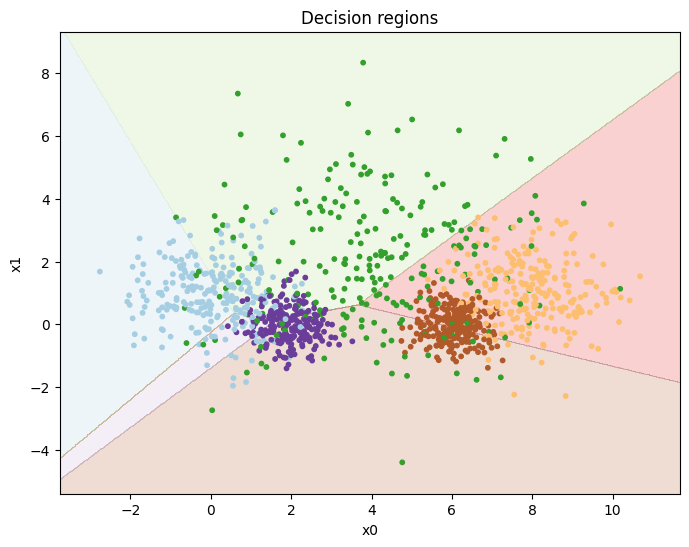

In [27]:
# Print section header
print("\n+------------------------------------------------+")
print("|   TASK II (5): ONE-VS-REST LOGISTIC REGRESSION  |")
print("+-------------------------------------------------+\n")

ovr_log_cl = OneVsRestLogisticRegression()
ovr_log_cl.fit(X_train, t_multi_train, X_val, t_multi_val)

train_accuracy = ovr_log_cl.accuracy(X_train, t_multi_train)
val_accuracy = ovr_log_cl.accuracy(X_val, t_multi_val)

print("(1) Final results for the one-vs-rest logistic regression model")
print("    + Accuracy + ")
print(f"       ---> training accuracy: {train_accuracy:.4f}")
print(f"       ---> validation accuracy: {val_accuracy:.4f}")

print("(2) Plotting of the decision boundaries")
plot_decision_regions(X_train, t_multi_train, ovr_log_cl)


# Testkoden:

Testkoden består av følgende trinn:

1. Opprett en instans av OneVsRestLogisticRegression-klassen.
2. Tren klassifikatoren ved å bruke fit-metoden med trenings- og valideringsdatasettene.
3. Beregn trenings- og valideringsnøyaktigheten ved hjelp av accuracy-metoden.
4. Skriv ut nøyaktighetsverdiene for trenings- og valideringsdatasettene.
5. Plott beslutningsgrensene for klassifikatoren ved å bruke plot_decision_regions-funksjonen. Denne funksjonen må oppdateres for å kunne håndtere flerklassedata.

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. 

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [28]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))
        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, eta=0.001, epochs = 100):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Itilaize the wights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        for e in range(epochs):
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights
            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

In [29]:
import numpy as np

def add_bias(X, bias):
    return np.hstack([np.full((X.shape[0], 1), bias), X])

class MLPBinaryLinRegClass(NumpyClassifier):
    def __init__(self, bias=-1, dim_hidden=6):
        self.bias = bias
        self.dim_hidden = dim_hidden

        def logistic(x):
            return 1 / (1 + np.exp(-x))
        self.activ = logistic

        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff

    def fit(self, X_train, t_train, eta=0.001, epochs=100, X_val=None, t_val=None, tol=1e-4, n_epochs_no_update=5):
        self.eta = eta

        T_train = t_train.reshape(-1, 1)
        if t_val is not None:
            T_val = t_val.reshape(-1, 1)

        dim_in = X_train.shape[1]
        dim_out = T_train.shape[1]

        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1) / np.sqrt(dim_in)
        self.weights2 = (np.random.rand(self.dim_hidden + 1, dim_out) * 2 - 1) / np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)

        if X_val is not None:
            X_val_bias = add_bias(X_val, self.bias)

        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []

        epochs_since_last_update = 0
        best_loss = float('inf')

        for e in range(int(epochs)):
            hidden_outs, outputs = self.forward(X_train_bias)
            out_deltas = (outputs - T_train)
            hiddenout_diffs = out_deltas @ self.weights2.T
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas

            train_loss.append(np.mean(np.square(out_deltas)))
            train_acc.append(np.mean(self.predict(X_train) == t_train))

            if X_val is not None and t_val is not None:
                val_outputs = self.forward(X_val_bias)[1]
                val_out_deltas = (val_outputs - T_val)
                val_loss.append(np.mean(np.square(val_out_deltas)))
                val_acc.append(np.mean(self.predict(X_val) == t_val))

                if val_loss[-1] < best_loss - tol:
                    best_loss = val_loss[-1]
                    epochs_since_last_update = 0
                else:
                    epochs_since_last_update += 1

                if epochs_since_last_update >= n_epochs_no_update:
                    break

        self.train_loss = train_loss
        self.train_acc = train_acc
        self.val_loss = val_loss
        self.val_acc = val_acc
        self.num_epochs_ran = e + 1

    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

In [30]:
print("\n+------------------------------------------------+")
print("|    TASK II (6): Multi-layer neural networks    |")
print("+------------------------------------------------+\n")

import numpy as np

# Generate some random data for testing
np.random.seed(123)
X_train = np.random.randn(10, 11)
t_train = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
X_val = np.random.randn(4, 11)
t_val = np.array([1, 0, 1, 0])

# Create and fit the classifier
mlp_cl = MLPBinaryLinRegClass()
mlp_cl.fit(X_train, t_train, eta=0.1, epochs=1000, X_val=X_val, t_val=t_val, tol=1e-5, n_epochs_no_update=5)

# Evaluate the classifier
train_loss = mlp_cl.train_loss[-1]
train_accuracy = mlp_cl.train_acc[-1]
val_loss = mlp_cl.val_loss[-1]
val_accuracy = mlp_cl.val_acc[-1]

print(f"Training loss: {train_loss:.4f}, accuracy: {train_accuracy:.4f}")
print(f"Validation loss: {val_loss:.4f}, accuracy: {val_accuracy:.4f}")

print("(1) Final results for the one-vs-rest logistic regression model")
print("    + Accuracy + ")
print(f"       ---> training accuracy: {train_accuracy:.4f}")
print(f"       ---> validation accuracy: {val_accuracy:.4f}")

print("    + Loss + ")
print(f"       ---> training loss: {train_loss:.4f}")
print(f"       ---> validation loss: {val_loss:.4f}")


+------------------------------------------------+
|    TASK II (6): Multi-layer neural networks    |
+------------------------------------------------+

Training loss: 0.1396, accuracy: 0.9000
Validation loss: 0.2199, accuracy: 0.5000
(1) Final results for the one-vs-rest logistic regression model
    + Accuracy + 
       ---> training accuracy: 0.9000
       ---> validation accuracy: 0.5000
    + Loss + 
       ---> training loss: 0.1396
       ---> validation loss: 0.2199


## For IN4050-students: Multi-class neural network

The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. (This is the most fun part of the set :) )

The goal is to use a feed-forward network for non-linear multi-class classfication and apply it to set (X, t_multi).

Modify the netork to become a multi-class classifier. As a check of your implementation, you may apply it to (X, t_2) and see whether you get similar results as above.

Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier..

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

In [38]:
# Import necessary libraries
import pandas as pd


# Instantiate classifiers
lin_cl = NumpyLinRegClass()
log_cl = NumpyLogisticRegression()
mlp_cl = MLPBinaryLinRegClass()

print("+----------------------------------+")
print("|    TASK III (7): Final Testing   |")
print("+----------------------------------+\n")




+----------------------------------+
|    TASK III (7): Final Testing   |
+----------------------------------+

